In [1]:

import numpy as np
import pandas as pd
from scripts.unsupervised_utils.filter_by_noise_ratio import filter_by_noise_ratio
from scripts.unsupervised_utils.paretos import extract_pareto_front
from scripts.Training.unsupervised.grid_search_hdbscan import run_hdbscan_grid
from scripts.Training.unsupervised.grid_search_knn import run_kmeans_grid
from scripts.Training.unsupervised.run_hdbscan_combinaison import  run_hdbscan_combinations
from scripts.Training.unsupervised.grid_search_clarans import run_clara_grid
from scripts.Training.unsupervised.run_algo import kmeans_with_map , hdbscan_with_map , clara_with_map
from scripts.utils.remove_desert import save_shapefile_north_of_latitude


from scripts.unsupervisedAlgofromScratch.run_algoscratch import clustering_with_map


output_shapefile_path = "../data/shapefiles/combined/north/north.shp"


save_shapefile_north_of_latitude(
    input_shapefile_path="../data/shapefiles/combined/full/",
    output_shapefile_path=output_shapefile_path,
    latitude_cut=34.0,
)


✅ Shapefile saved:
   ../data/shapefiles/combined/north/north.shp
   (North of latitude 34.0)


,GID_0,COUNTRY,geometry
0,DZA,Algeria,"MULTIPOLYGON (((2.84413 36.74151, 2.84535 36.7..."
1,TUN,Tunisia,"MULTIPOLYGON (((7.55636 34.00558, 7.5602 34.01..."


## Load data

In [2]:

# -----------------------------
# 1. Load your data
# -----------------------------
data_path_32 = "../data/preprocessed/preprocessed_reduced_unsupervised_32.csv"
X_data_32 = pd.read_csv(data_path_32)



data_path_10 = "../data/preprocessed/preprocessed_reduced_unsupervised_10.csv"
X_data_10 = pd.read_csv(data_path_10)

shapefile_path = "../data/shapefiles/combined/north/north.shp"

print("Data shape after sampling (k-mean):", X_data_32.shape)
print("Data shape after sampling (dbscan):", X_data_10.shape)

Data shape after sampling (k-mean): (735483, 33)
Data shape after sampling (dbscan): (735483, 12)


## K-mean

In [21]:
results = run_kmeans_grid(
    X=X_data_32,
    k_values=list(range(3, 51)),  # 3,5,7,...,49
    output_path="./results/knn_metrics.csv",
    algorithm="minibatch_kmeans",  
    batch_size=4096,
    metrics=("ch", "dbi","wcss"),
)



minibatch_kmeans Grid Search: 100%|██████████| 48/48 [02:12<00:00,  2.76s/it]


In [ ]:
pareto = extract_pareto_front(
    csv_path="./results/knn_metrics.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

    K       init         algorithm             CH       DBI  WCSS_per_point
0   3  k-means++  minibatch_kmeans  254988.834430  1.721380       16.684688
1   5  k-means++  minibatch_kmeans  180414.047959  1.701579       14.263527
2   8  k-means++  minibatch_kmeans  147410.138872  1.512309       11.756861
3  11  k-means++  minibatch_kmeans  126335.821244  1.505054       10.413611
4  12  k-means++  minibatch_kmeans  125704.384579  1.368123        9.811640
5  13  k-means++  minibatch_kmeans  124980.671951  1.341546        9.296829
6  14  k-means++  minibatch_kmeans  120858.929637  1.329219        9.021307
7  16  k-means++  minibatch_kmeans  115956.241494  1.277816        8.403590
8  21  k-means++  minibatch_kmeans  117611.923318  1.288624        6.730543
9  26  k-means++  minibatch_kmeans  110334.797442  1.211595        5.948190


In [32]:
results = run_kmeans_grid(
    X=X_data_32,
    k_values=[3,5,8,11,12,14,16,21,26],  # 3,5,7,...,49
    n_init=10,
    output_path="./results/knn_silhouette.csv",
    algorithm="minibatch_kmeans",  
    batch_size=4096,
    metrics=("silhouette"),
)


minibatch_kmeans Grid Search: 100%|██████████| 9/9 [55:06<00:00, 367.38s/it]


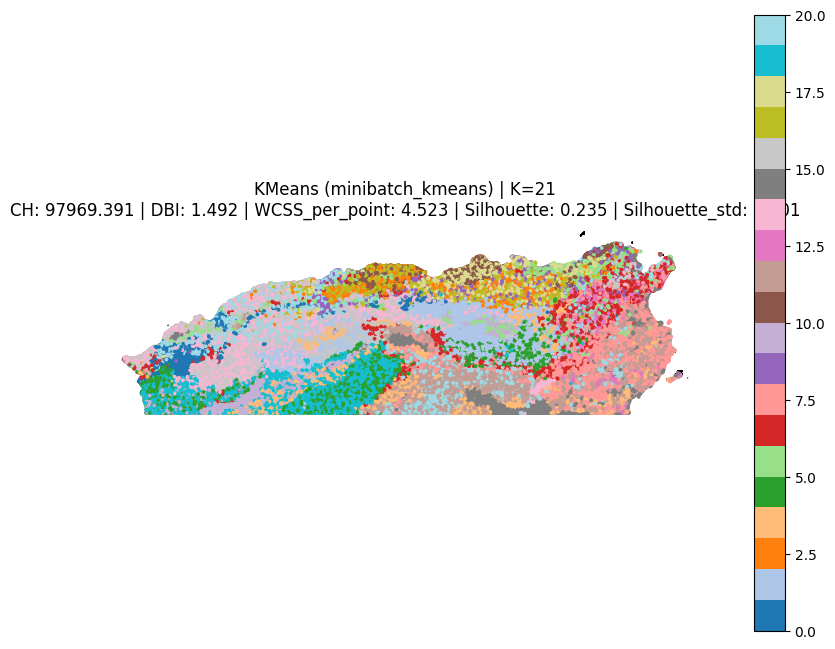

In [9]:
gdf_km, km_metrics = kmeans_with_map(
    df=X_data_32,
    shapefile_path=shapefile_path,
    k_value=21,
    algorithm="minibatch_kmeans",

)

## HDBSCAN 

In [ ]:
results = run_hdbscan_grid(
    X=X_data_10,
    min_cluster_sizes=[50, 100, 200, 500, 1000],
    min_samples_values=[5, 10, 20, 50],
    output_path="./results/hdbscan_results.csv",
    metrics=("ch", "dbi", "wcss"),
)


In [5]:
filter_by_noise_ratio("./results/hdbscan_results.csv","./results/hdbscan_results_filtered.csv",min_noise_ratio=0.2)

Saved 18 / 20 rows to ./results/hdbscan_results_filtered.csv


In [8]:
pareto = extract_pareto_front(
    csv_path="./results/hdbscan_results_filtered.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

  algorithm  min_cluster_sizes  min_samples  n_clusters  n_noise  noise_ratio  \
0   hdbscan                 50           10        4705   141521     0.192419   
1   hdbscan                100           50        1117   133634     0.181696   
2   hdbscan                200           20         661    88982     0.120984   
3   hdbscan                200           50         550    97745     0.132899   
4   hdbscan                500           50         295    93779     0.127507   
5   hdbscan               1000           50         174   107191     0.145742   

             CH       DBI  
0   9613.115812  0.840261  
1  12354.581973  0.955520  
2  15974.816742  1.205005  
3  15464.683693  1.118552  
4  24703.715102  1.334042  
5  29329.604731  1.458920  


In [ ]:
param_combinations = [
    {"min_cluster_size": 50, "min_samples": 10},
    {"min_cluster_size": 100, "min_samples": 50},
    {"min_cluster_size": 200, "min_samples": 20},
    {"min_cluster_size": 200, "min_samples": 50},
    {"min_cluster_size": 500, "min_samples": 50},
    {"min_cluster_size": 1000, "min_samples": 50},
    
]

df = run_hdbscan_combinations(
    X=X_data_10,
    param_combinations=param_combinations,
    output_path="./results/hdbscan_selected_runs.csv",
    metrics=("ch", "dbi","silhouette"),
)


HDBSCAN Runs:  17%|█▋        | 1/6 [12:31<1:02:36, 751.36s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 10, 'n_clusters': 4705, 'n_noise': np.int64(141521), 'noise_ratio': np.float64(0.19241913137353275), 'CH': 9613.115812421172, 'DBI': 0.8402605206507678, 'Silhouette': np.float64(0.415047631999162), 'Silhouette_std': np.float64(0.0012099766964917239)}


HDBSCAN Runs:  33%|███▎      | 2/6 [21:20<41:23, 620.80s/it]  

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 50, 'n_clusters': 1117, 'n_noise': np.int64(133634), 'noise_ratio': np.float64(0.1816955660429949), 'CH': 12354.581972751314, 'DBI': 0.9555195940977038, 'Silhouette': np.float64(0.24981478331024148), 'Silhouette_std': np.float64(0.001807645142020548)}


HDBSCAN Runs:  50%|█████     | 3/6 [29:19<27:47, 555.78s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 20, 'n_clusters': 661, 'n_noise': np.int64(88982), 'noise_ratio': np.float64(0.1209844415166632), 'CH': 15974.81674241059, 'DBI': 1.205005259036342, 'Silhouette': np.float64(0.21911689986108668), 'Silhouette_std': np.float64(0.001626174528131428)}


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
HDBSCAN Runs:  67%|██████▋   | 4/6 [37:17<17:30, 525.14s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 50, 'n_clusters': 550, 'n_noise': np.int64(97745), 'noise_ratio': np.float64(0.13289906088923878), 'CH': 15464.683692850305, 'DBI': 1.1185523937460142, 'Silhouette': np.float64(0.22099316894987764), 'Silhouette_std': np.float64(0.0016330261896091833)}


HDBSCAN Runs:  83%|████████▎ | 5/6 [44:55<08:20, 500.89s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 50, 'n_clusters': 295, 'n_noise': np.int64(93779), 'noise_ratio': np.float64(0.12750668608247914), 'CH': 24703.715102483402, 'DBI': 1.3340416980474894, 'Silhouette': np.float64(0.22021246746883166), 'Silhouette_std': np.float64(0.0010693207788540038)}


HDBSCAN Runs: 100%|██████████| 6/6 [52:35<00:00, 526.00s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 50, 'n_clusters': 174, 'n_noise': np.int64(107191), 'noise_ratio': np.float64(0.1457423217123985), 'CH': 29329.604730543622, 'DBI': 1.4589200360601353, 'Silhouette': np.float64(0.20762483780073993), 'Silhouette_std': np.float64(0.001571614176482901)}


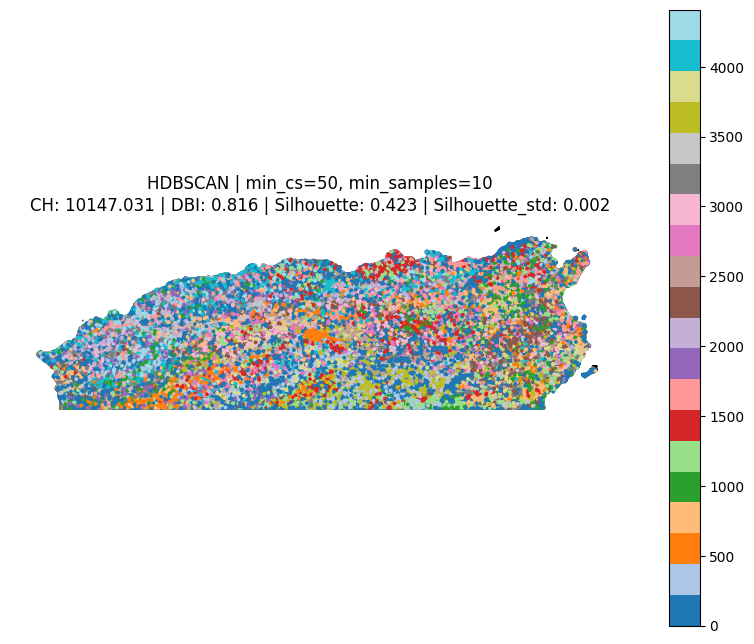

In [14]:
gdf_hdb, hdb_metrics = hdbscan_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    min_cluster_size=50,
    min_samples=10,
)

## Clarans

In [4]:
# Redémarrer le kernel d'abord (Kernel -> Restart Kernel)

# Puis réimporter
from scripts.Training.unsupervised.grid_search_clarans import run_clara_grid

# Maintenant ça devrait marcher
results = run_clara_grid(
    X=X_data_32,
    k_values=range(3, 21, 2),
    n_sampling_values=[40, 80],
    n_sampling_iter_values=[3, 5],
    max_iter_values=[300],
    output_path="./results/clara_results.csv",
    metrics=("ch", "dbi", "avg_medoid_dist"),
)


CLARA Grid Search: 100%|██████████| 36/36 [05:26<00:00,  9.07s/it]


In [3]:
pareto = extract_pareto_front(
    csv_path="./results/clara_results.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

    K  n_sampling  n_sampling_iter  max_iter algorithm     best_cost  \
0   3          40                3       300     clara  2.682655e+06   
1   3          40                5       300     clara  2.708922e+06   
2   3          80                5       300     clara  2.656007e+06   
3   5          40                3       300     clara  2.477603e+06   
4   9          80                5       300     clara  2.112577e+06   
5  15          40                3       300     clara  1.870367e+06   
6  15          80                5       300     clara  1.836285e+06   

              CH       DBI  AvgMedoidDist  
0  120462.624690  2.135016       3.647473  
1  110730.519662  2.000123       3.683187  
2  115023.007634  2.056333       3.611241  
3  106805.179721  1.721914       3.368674  
4  105583.021547  1.508455       2.872366  
5  100697.664390  1.441036       2.543046  
6  100989.533940  1.492402       2.496707  


In [4]:

best_configs = [
    {"K": 3, "n_sampling": 40, "n_sampling_iter": 3},
    {"K": 3, "n_sampling": 40, "n_sampling_iter": 5},
    {"K": 3, "n_sampling": 80, "n_sampling_iter": 5},
    {"K": 5, "n_sampling": 40, "n_sampling_iter": 3},
    {"K": 9, "n_sampling": 80, "n_sampling_iter": 5},
    {"K": 15, "n_sampling": 40, "n_sampling_iter": 3},
    {"K": 15, "n_sampling": 80, "n_sampling_iter": 5},
]

# Extraire les valeurs uniques
k_values = sorted(set([c["K"] for c in best_configs]))
n_sampling_values = sorted(set([c["n_sampling"] for c in best_configs]))
n_sampling_iter_values = sorted(set([c["n_sampling_iter"] for c in best_configs]))

print(f"K values: {k_values}")
print(f"n_sampling: {n_sampling_values}")
print(f"n_sampling_iter: {n_sampling_iter_values}")

# Grid search avec Silhouette
results = run_clara_grid(
    X=X_data_32,
    k_values=k_values,  # [3, 5, 9, 15]
    n_sampling_values=n_sampling_values,  # [40, 80]
    n_sampling_iter_values=n_sampling_iter_values,  # [3, 5]
    max_iter_values=[300],
    output_path="./results/clara_silhouette.csv",
    metrics=("ch", "dbi", "silhouette"),  # Ajout du Silhouette
)


K values: [3, 5, 9, 15]
n_sampling: [40, 80]
n_sampling_iter: [3, 5]


CLARA Grid Search: 100%|██████████| 16/16 [30:01<00:00, 112.62s/it]


In [3]:
# Charger les résultats
df_silhouette = pd.read_csv("./results/clara_silhouette.csv")

# Trier par Silhouette (décroissant = meilleur)
df_sorted = df_silhouette.sort_values('Silhouette', ascending=False)

print("Top 5 configurations par Silhouette:")
print(df_sorted[['K', 'n_sampling', 'n_sampling_iter', 
                 'CH', 'DBI', 'Silhouette', 'Silhouette_std']].head())


Top 5 configurations par Silhouette:
     K  n_sampling  n_sampling_iter             CH       DBI  Silhouette  \
11   9          80                5  100800.712316  1.462383    0.207619   
10   9          80                3   94335.209118  1.531170    0.205920   
13  15          40                5   89289.653560  1.634631    0.203423   
14  15          80                3   95063.133179  1.593293    0.201981   
15  15          80                5   93693.557523  1.636678    0.198363   

    Silhouette_std  
11        0.000966  
10        0.000474  
13        0.001623  
14        0.000852  
15        0.000415  


In [4]:
# Meilleure config = Silhouette le plus élevé
best_row = df_sorted.iloc[0]

print("\n🏆 Meilleure configuration CLARA:")
print(f"K = {int(best_row['K'])}")
print(f"n_sampling = {int(best_row['n_sampling'])}")
print(f"n_sampling_iter = {int(best_row['n_sampling_iter'])}")
print(f"\nMétriques:")
print(f"  CH = {best_row['CH']:.2f}")
print(f"  DBI = {best_row['DBI']:.3f}")
print(f"  Silhouette = {best_row['Silhouette']:.4f} ± {best_row['Silhouette_std']:.4f}")



🏆 Meilleure configuration CLARA:
K = 9
n_sampling = 80
n_sampling_iter = 5

Métriques:
  CH = 100800.71
  DBI = 1.462
  Silhouette = 0.2076 ± 0.0010


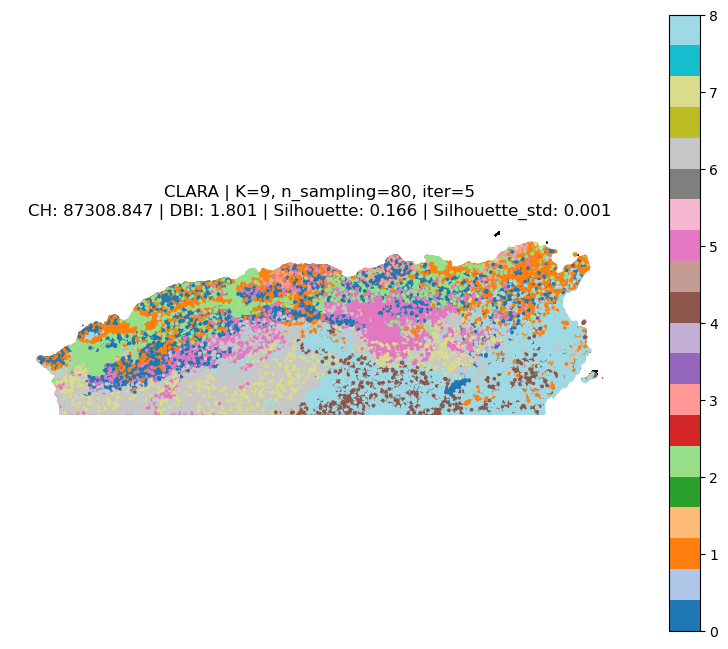

In [5]:
# Visualiser la meilleure configuration
gdf, metrics = clara_with_map(
    df=X_data_32,
    shapefile_path="../data/shapefiles/combined/north/north.shp",
    k_value=int(best_row['K']),
    n_sampling=int(best_row['n_sampling']),
    n_sampling_iter=int(best_row['n_sampling_iter']),
    max_iter=300,
    metrics=("ch", "dbi", "silhouette"),
)


In [10]:
# CLARA - avec Silhouette + CH + DBI
df_clara = pd.read_csv("./results/clara_silhouette.csv")
best_clara = df_clara.sort_values('Silhouette', ascending=False).iloc[0]

# K-Means - fusionner les deux fichiers
df_kmeans_metrics = pd.read_csv("./results/knn_metrics.csv")  # CH, DBI
df_kmeans_sil = pd.read_csv("./results/knn_silhouette.csv")    # Silhouette

# Merger sur K
df_kmeans = df_kmeans_sil.merge(
    df_kmeans_metrics[['K', 'CH', 'DBI']], 
    on='K', 
    how='left'
)
best_kmeans = df_kmeans.sort_values('Silhouette', ascending=False).iloc[0]

print("=" * 70)
print("📊 COMPARAISON CLARA vs K-MEANS")
print("=" * 70)

print(f"\n🔵 CLARA (K={int(best_clara['K'])}):")
print(f"  Silhouette: {best_clara['Silhouette']:.4f} ± {best_clara.get('Silhouette_std', 0):.4f}")
print(f"  CH:         {best_clara['CH']:.2f}")
print(f"  DBI:        {best_clara['DBI']:.3f}")
print(f"  Config:     n_sampling={int(best_clara['n_sampling'])}, iter={int(best_clara['n_sampling_iter'])}")

print(f"\n🟢 K-Means (K={int(best_kmeans['K'])}):")
print(f"  Silhouette: {best_kmeans['Silhouette']:.4f} ± {best_kmeans.get('Silhouette_std', 0):.4f}")
print(f"  CH:         {best_kmeans['CH']:.2f}")
print(f"  DBI:        {best_kmeans['DBI']:.3f}")

# Déterminer le gagnant
scores = {
    'CLARA': best_clara['Silhouette'],
    'K-Means': best_kmeans['Silhouette'],
}
winner = max(scores, key=scores.get)

print(f"\n🏆 Meilleur algorithme: {winner} ({scores[winner]:.4f})")
print("=" * 70)

# Tableau récapitulatif
comparison = pd.DataFrame({
    'Algorithme': ['CLARA', 'K-Means'],
    'K': [int(best_clara['K']), int(best_kmeans['K'])],
    'Silhouette': [f"{best_clara['Silhouette']:.4f}", f"{best_kmeans['Silhouette']:.4f}"],
    'CH': [f"{best_clara['CH']:.0f}", f"{best_kmeans['CH']:.0f}"],
    'DBI': [f"{best_clara['DBI']:.3f}", f"{best_kmeans['DBI']:.3f}"]
})

print("\n📋 TABLEAU RÉCAPITULATIF:")
print(comparison.to_string(index=False))


📊 COMPARAISON CLARA vs K-MEANS

🔵 CLARA (K=9):
  Silhouette: 0.2076 ± 0.0010
  CH:         100800.71
  DBI:        1.462
  Config:     n_sampling=80, iter=5

🟢 K-Means (K=26):
  Silhouette: 0.2678 ± 0.0005
  CH:         110334.80
  DBI:        1.212

🏆 Meilleur algorithme: K-Means (0.2678)

📋 TABLEAU RÉCAPITULATIF:
Algorithme  K Silhouette     CH   DBI
     CLARA  9     0.2076 100801 1.462
   K-Means 26     0.2678 110335 1.212


# From Scratch


### K-means

In [4]:
# Import
from scripts.unsupervisedAlgofromScratch.run_algoscratch import clustering_with_map

gdf_km, km_metrics = clustering_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    algorithm="kmeans_scratch",
    k_value=21,
    max_iter=300,
    n_init=10,
    metrics=("ch", "dbi", "wcss", "silhouette"),
    random_state=42,
)



🗺️  K-MEANS CLUSTERING AVEC CARTE (K=21)
📊 Nombre de points: 735,483
📈 Features utilisées: 10
🔧 Algorithme: kmeans_scratch
⚙️  Entraînement K-means from scratch (n_init=10)...


KeyboardInterrupt: 

# DBSCAN

In [3]:
gdf_hdbscan, hdbscan_metrics = clustering_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    algorithm="hdbscan_scratch",
    min_cluster_size=50,
    min_samples=10,
    metrics=("ch", "dbi", "silhouette"),
    random_state=42,
)



🗺️  HDBSCAN CLUSTERING AVEC CARTE (min_cluster_size=50, min_samples=10)
📊 Nombre de points: 735,483
📈 Features utilisées: 10
🔧 Algorithme: hdbscan_scratch
⚙️  Entraînement HDBSCAN from scratch...


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyboardInterrupt: 

# Clara

In [4]:
gdf_clara, clara_metrics = clustering_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    algorithm="clara_scratch",
    k_value=9,
    n_sampling=80,
    n_sampling_iter=5,
    metrics=("ch", "dbi", "silhouette"),
    random_state=42,
)



🗺️  CLARA CLUSTERING AVEC CARTE (K=9)
📊 Nombre de points: 735,483
📈 Features utilisées: 10
🔧 Algorithme: clara_scratch
⚙️  Entraînement CLARA from scratch (n_sampling=80, n_sampling_iter=5)...


KeyboardInterrupt: 